# Initial Analysis
---

Specifically, “Physical activity was assessed on at least three days (one weekend day, and two weekdays).  Total activity counts (AC) per day over the course of time with which the monitor was worn were calculated. Then, to derive average total AC per day, this number was divided by the total
number of valid days worn. Ultimately, total average daily steps, as well as the time that was spent in sedentary, light, moderate, and strenuous activity was provided.”


### References
* Markers of branched-chain amino acid catabolism are not affected by exercise training in pregnant women with obesity
Brittany R. Allman, Beverly J. Spray, Kelly E. Mercer, Aline Andres, and Elisabet Børsheim
Journal of Applied Physiology 2021 130:3, 651-659; [https://doi.org/10.1152/japplphysiol.00673.2020](https://doi.org/10.1152/japplphysiol.00673.2020)
*Diaz, EC, Cleves, MA, DiCarlo, M, et al. Parental adiposity differentially associates with newborn body composition. Pediatric Obesity. 2020; 15:e12596. [https://doi.org/10.1111/ijpo.12596](https://doi.org/10.1111/ijpo.12596)


### Acronym
* **PA**: physical activity
* **AC**: activity count

## Objective

* **Assess PA on at least 3 days (5 days max) including one weekend day and 2 weekdays. We exclude incomplete day, i.e. the first day and the last day.**
    * *Create a function to select week day versus weekend day.*
* **Total AC per day over the minimum of day**
    * *Create a function to find the minimum of day.*
* **Average AC per day**
* **Total average daily steps**
* **Time spent in sedentary, light, moderate and vigorous activity** 

## Load input: packages, external functions, input data.

### Packages

In [1]:
############
# PACKAGES #
###########

using DataFrames, Dates, CSV, Missings
using PyPlot, StatsBase, FreqTables
PyPlot.svg(true)
ioff() # Interactive plotting OFF, necessary for inline plotting in IJulia

PyObject <matplotlib.pyplot._IoffContext object at 0x000000003DB66130>

### External Functions

In [2]:
######################
# External Functions #
######################

# Include the modules directory
dirFun = realpath("../src/")
include(dirFun*"/ActStatData.jl"); # include(dirFun*"/ActPlotData.jl"))
include(dirFun*"/GetBio.jl");
include(dirFun*"/ActTools.jl");
include(dirFun*"/AccDynamics.jl");


### Data

In [30]:
# List of visit directories
listDir = ["/../data/Baseline Visit Data/";
           "/../data/32 Week Gestation Data/";
           "/../data/6 Week PP Data/";
           "/../data/6 Months PP Data/";
           "/../data/12 Months PP Data/"]

# Visit Dictionary 
dictVisitName =  Dict(1=>"VisitBaseline",
                    2=>"Visit32w",
                    3=>"Visit6wPP",
                    4=>"Visit6mPP",
                    5=>"Visit12mPP");

# Load the group assignment information
groupFileName = realpath(string(@__DIR__, "/../data/Group/group_assignement.csv"))
global dfGroup = CSV.read(groupFileName, DataFrame);
sort!(dfGroup);


Extract data for one visit:

In [31]:
visit = 1
# Get the path of the directory 
myDir = abspath(string(@__DIR__,listDir[visit]));

# Get the data list files from the directory myDir
(actFiles, bioFiles) = ActStatData.filesNoNaN(myDir);

There is no missing (i.e. NA) data log in the following directory:
C:\git\senresearch\AccelerometerDataProcessing\data\Baseline Visit Data\


## Investigate complete days

Create a data frame containing number of complete days per ID for a specific visit. 

In [32]:
# Build data frame that contains study ID, number of complete days

# Initialize
n = length(actFiles) # number of individuals
vecTest = Array{String,1}(undef, 1)
dfXplore = DataFrame(ID = Array{Int64,1}(undef, n),
                     CompleteDays = Array{Int64,1}(undef, n))

for i in 1:n
    # Get ID 
    vecTest[1] = myDir*bioFiles[i] # file names of individuals for the visit
    dfXplore[i,1] =  GetVisitBio(vecTest)[1,1]; # get bio information
    
    dfAct = ActStatData.readActivity(myDir*actFiles[i]); # read activity 
    dfXplore[i,2] =  ActStatData.getCompleteDays(dfAct); # assess number of complete days
end


describe(dfXplore)[2,:]

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
2,CompleteDays,10.5165,5,8.0,83,0,Int64


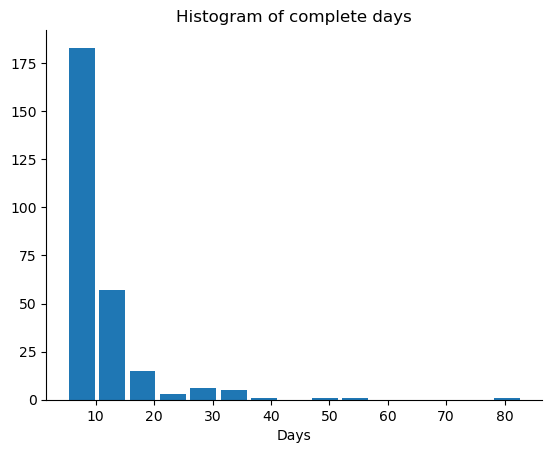

In [33]:
hist(dfXplore.CompleteDays,15, rwidth=0.85);
xlabel("Days");
title("Histogram of complete days");
ax2 = gca();
ax2.spines["top"].set_visible(false); # Hide the top edge of the axis
ax2.spines["right"].set_visible(false); # Hide the right edge of the axis

In [36]:
 filter(row -> row.CompleteDays <= 5, dfXplore)

,ID,CompleteDays
,Int64,Int64
1,81,5
2,107,5
3,224,5
4,247,5
5,593,5
6,777,5
7,779,5
8,792,5


In [38]:
# get id with 5 or less complete days
vecID = filter(row -> row.CompleteDays <= 5, dfXplore)[!, 1]
# indices of IDs
idxID  = findall(x -> x ⊆ vecID, dfXplore.ID)

8-element Vector{Int64}:
  15
  21
  38
  43
 150
 219
 220
 226

## Investigate accumulative PA

Generate histogram of accumulative PA. 

In [39]:
# Initialize
n = length(actFiles) # number of individuals
vAccPA = zeros(5*n)
global counter = 0

for i in 1:n  
    dfAct = ActStatData.readActivity(myDir*actFiles[i]); # read data from individual file
    numDays = ActStatData.getCompleteDays(dfAct); # get number of complete days 
    dfAct = ActStatData.getCompleteDays(dfAct, true); # return activity data frame for complete days
    for j in 2:6
        counter += 1
         vAccPA[counter] = sum(dfAct.ActivityCounts[findall(x -> x == j, dfAct.Day)]) # estimate accumulative PA
    end
end


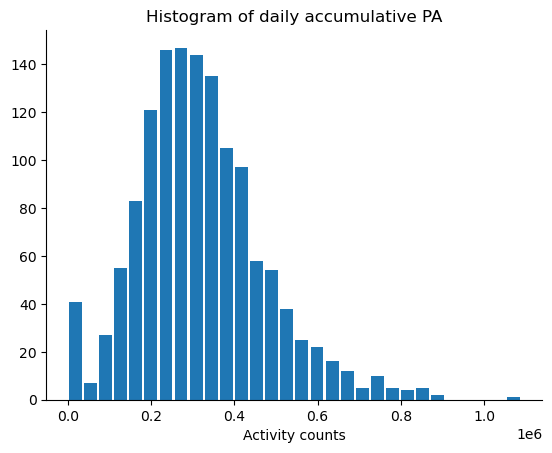

In [40]:
hist(vAccPA,30, rwidth=0.85);
xlabel("Activity counts");
title("Histogram of daily accumulative PA");
ax2 = gca();
ax2.spines["top"].set_visible(false); # Hide the top edge of the axis
ax2.spines["right"].set_visible(false); # Hide the right edge of the axis


### Find IDs containing 0 accumulative PA counts

In [41]:
# find indices with 0 accumulated activity counts 
idx0Acc = findall(x -> x == 0, vAccPA)
# tabulate number days with 0 AC per individual
idxFile = unique(ceil.(Int64, idx0Acc./5))
studyID0Acc = unique(dfXplore.ID[ceil.(Int64, idx0Acc./5)])
ft = freqtable(dfXplore.ID[ceil.(Int64, idx0Acc./5)])

10-element Named Vector{Int64}
Dim1  │ 
──────┼──
58    │ 2
181   │ 1
293   │ 2
423   │ 2
527   │ 2
571   │ 1
577   │ 1
792   │ 3
842   │ 1
897   │ 4

The individuals 897 and 792 have insufficient number of days.

### Check which days of the week
Confirm that complete days contains at least 2 week day and one weekend with none 0 acccumulative AC. 

In [42]:
dfPrblm =  DataFrame(index = idxFile, ID = dfXplore.ID[idxFile], NumEmptyDay = ft)
dfPrblm = filter(row -> row.NumEmptyDay < 3, dfPrblm )

,index,ID,NumEmptyDay
,Int64,Int64,Int64
1,10,58,2
2,26,181,1
3,59,293,2
4,98,423,2
5,129,527,2
6,141,571,1
7,143,577,1
8,243,842,1


`Dates.dayname()` function returns the name of the day according to the date.
`Dates.dayofweek()` function returns the day number of the week according to the date.   

|Day | Day number of the week|
|:---|----------------------:|
|Monday|1 |
|Tuesday|2 |
|Wednesday|3 |
|Thursday|4 |
|Friday|5 |
|Saturday|6|
|Sunday|7 |


In [43]:
# Get any file and show columns of the data frame structure
df = ActStatData.readActivity(myDir*actFiles[dfPrblm.index[1]]);
df = ActStatData.getCompleteDays(df, true);

In [44]:
global nameDays = ""
vName = Array{String, 1}(undef, size(dfPrblm)[1])
for j in 1:size(dfPrblm)[1] 
    df = ActStatData.readActivity(myDir*actFiles[dfPrblm.index[j]]);
    df = ActStatData.getCompleteDays(df, true);
    for i in 2:5
        if sum(df.ActivityCounts[findall(x -> x == i, df.Day)]) != 0
            Dates.dayname.((df.DateTime))
            nameDays = string(nameDays, " ", 
                Dates.dayname(df.DateTime[findfirst(x -> x == i, df.Day)]))
        end
    end
    vName[j] = nameDays
    nameDays = ""
    
end
dfPrblm[:, :CompleteDays] =  vName;
dfPrblm

,index,ID,NumEmptyDay,CompleteDays
,Int64,Int64,Int64,String
1,10,58,2,Wednesday Thursday Friday
2,26,181,1,Wednesday Friday Saturday
3,59,293,2,Thursday Sunday
4,98,423,2,Wednesday Thursday Friday
5,129,527,2,Tuesday Wednesday Friday
6,141,571,1,Wednesday Thursday Friday Saturday
7,143,577,1,Saturday Sunday Monday Tuesday
8,243,842,1,Tuesday Wednesday Thursday Friday


### Ignore potential ID

Filter files with at least 5 complete days.

In [45]:
# get indices
idxID5days = findall(x -> x ⊈ dfPrblm.index, collect(1:length(actFiles)));

# filter files
actFiles5days = actFiles[idxID5days];
bioFiles5days = bioFiles[idxID5days];

### Assess week days requirement

In [46]:
# convert datetime to only 
vWeekDayCode = collect(1:5)
vWeekendDayCode = collect(6:7);

In [47]:
df = ActStatData.readActivity(myDir*actFiles[141]);
df = ActStatData.getCompleteDays(df, true);

In [48]:
indivDayOfWeek = unique(Dates.dayofweek.((df.DateTime)))

7-element Vector{Int64}:
 3
 4
 5
 6
 7
 1
 2

In [49]:
# create a set containing week days: 1 (Monday) to 5 (Friday) 
vWeekDayCode = collect(1:5)
# create a set containing weekend days: 6 (Saturday) to 5 (Sunday)
vWeekendDayCode = collect(6:7);

# initialize
numWeekDay = 0
numWeekEndDay = 0

# get data
dfAct = ActStatData.readActivity(myDir*actFiles[1]);
numDays = ActStatData.getCompleteDays(dfAct);

# keep only complete days
dfAct = ActStatData.getCompleteDays(dfAct, true);

# keep non-zero accumulative AC days
dfAct = filterAccDays(dfAct);

# get days of the week
indivDayOfWeek = unique(Dates.dayofweek.((dfAct.DateTime)))

numDays = length(indivDayOfWeek)

# check if days meet requirements
for i in 1:numDays
    if indivDayOfWeek[i] ⊆ vWeekDayCode
        numWeekDay += 1
    else
        numWeekEndDay += 1
    end
end

if (numWeekDay >= 2) & (numWeekEndDay >= 1)
    areDaysOk = true
else 
    areDaysOk = false
end
display(indivDayOfWeek)
areDaysOk

# TO DO create full data frame then filter files with flag and select -flag


7-element Vector{Int64}:
 3
 4
 5
 6
 7
 1
 2

true

In [61]:
dfAct = dfAct[dfAct[!, :Day] .== 2, :];
vIntensity = dfAct.ActivityIntensity[dfAct.Day .== 2,1] 
countmap(vIntensity)

Dict{Int64, Int64} with 3 entries:
  2 => 706
  3 => 170
  1 => 564

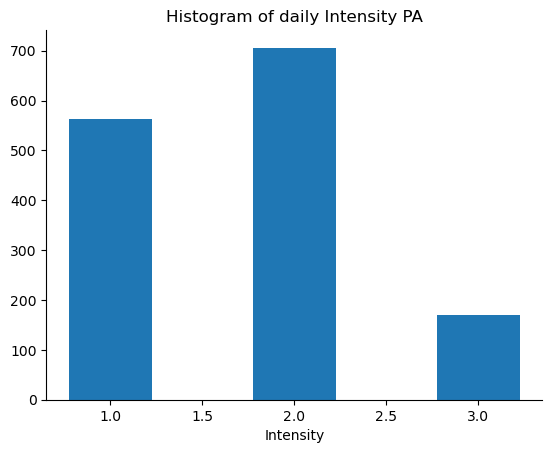

In [97]:
hist(vIntensity,bins = [0.75,1.25,1.75,2.25,2.75,3.25], rwidth= 0.9);
xlabel("Intensity");
title("Histogram of daily Intensity PA");


ax2 = gca();
ax2.spines["top"].set_visible(false); # Hide the top edge of the axis
ax2.spines["right"].set_visible(false); # Hide the right edge of the axis


### Filter days with accumulative activities 

Generate histogram of accumaltive PA. 

In [26]:
"""
**`filterAccDays`** -*Function*.

    `filterAccDays(myDf::DataFrames.DataFrame)` => `Int64`

Filters days with zero acccumulative acitivity counts, and returns filtered data frame.

"""
function filterAccDays(myDf::DataFrames.DataFrame, )
    # initialize
    numDays = length(unique(myDf.Day))
    vAccAC = zeros(numDays)
        
    # estimate accumulative activity counts for each complete days
    for j in 2:(numDays+1)
         vAccAC[j-1] = sum(dfAct.ActivityCounts[findall(x -> x == j, myDf.Day)])
    end
    
    # get days where acc AC is strictly positive
    dayAccAC = findall(x -> x > 0,  vAccAC) .+ 1
    
    # filter days with zero accumulative activity counts
    filter!(row -> row.Day ⊆ dayAccAC, myDf)
    
    return myDf  
end

filterAccDays